In [1]:
from utils.utils import train_model, evaluate_model_with_cm, TiffDataset
from models.video_classifier import VideoClassifier, TransformerModel
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.init as init

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
val_filter = lambda x: x >= 1 and (x % 50) in {1, 6, 13, 18, 25, 30, 32, 37, 44, 49}

In [5]:
bands = 4
num_epochs = 100
os.makedirs("./checkpoints/patch_size_test", exist_ok=True) #checkpoints 저장할 dir
large_tif_dir = '../../data/source_data/naive' #원천데이터 주소

class ReshapeTransform:
    """(12*bands, 3, 3) → (12, bands, 3, 3) 변환"""
    def __init__(self, bands, patch_size):
        self.bands = bands
        self.patch_size = patch_size
    def __call__(self, x):
        return x.view(12, self.bands, self.patch_size, self.patch_size).permute(1, 0, 2, 3)

def get_transform(bands, patch_size, scale_channels_func=None):
    transform_list = [
        transforms.ToTensor(),  # (H, W, C) → (C, H, W)
        transforms.Lambda(lambda x: x.float()),  # uint16 → float 변환
        ReshapeTransform(bands, patch_size)  # (12*bands, 3, 3) → (bands, 12, 3, 3)
    ]

    if scale_channels_func:
        transform_list.append(transforms.Lambda(scale_channels_func))  # 채널별 값 조정 추가

    return transforms.Compose(transform_list)

#scaling 함수 - 채널별로 범위의 차이가 크기때문에 어느정도 맞추어주기 위해서 수행
def scale_channels(x):
    """특정 채널값 조정"""
    x[0:3] *= 5  # B,G,R 채널 * 5
    if 4 < x.shape[0]:
        x[4] *= 0.5  # NDVI 채널 * 0.5
    return x


patch_size = 1

transform = get_transform(bands, patch_size, scale_channels)

train_dataset = TiffDataset(
            large_tif_dir = large_tif_dir,
            file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
            label_file = "../../data/label_data/species/label_mapping_sampled.csv",
            box_filter_fn = lambda box_number: not val_filter(box_number),
            patch_size = patch_size,
            transform=transform
        )

val_dataset = TiffDataset(
            large_tif_dir = large_tif_dir,
            file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
            label_file ="../../data/label_data/species/label_mapping_sampled.csv",
            box_filter_fn = val_filter,
            patch_size = patch_size,
            transform=transform
        )

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

model = TransformerModel(patch_size=patch_size).to(device)
model.load_state_dict(torch.load(f"./checkpoints/patch_size_test/transformer_{bands}_{patch_size}_{num_epochs}.pth"))

<All keys matched successfully>

In [47]:
import torch
import torch.nn as nn

def analyze_time_step_importance(model):
    """
    Transformer 모델에서 각 시기(temporal step)가 logit 형성에 미치는 영향을 분석하는 함수.

    Args:
        model (nn.Module): Transformer 기반 분류 모델

    Returns:
        torch.Tensor: (temp, num_classes) 크기의 행렬, 각 시기의 중요도 값
    """
    # 모델 구조에서 필요한 정보 추출
    temp = model.num_tokens  # 시기의 개수 (예: 12)
    d_model = model.d_model  # 각 시기의 임베딩 차원

    # 모델의 FC 레이어 가져오기 (Flatten 이후)
    fc_layers = [layer for layer in model.fc if isinstance(layer, nn.Linear)]
    assert len(fc_layers) > 0, "FC 레이어가 없습니다."

    # 모든 FC 레이어의 가중치 가져오기
    weights = [layer.weight.abs() for layer in fc_layers]  # 절대값 취함

    # 첫 번째 FC의 입력 차원 확인 (Flatten 크기)
    flatten_dim = weights[0].shape[1]  # 첫 번째 FC의 입력 차원
    num_classes = weights[-1].shape[0]  # 최종 logit 차원

    # 첫 번째 FC의 가중치를 원래 Transformer 출력 차원으로 변형
    W1 = weights[0].view(temp, d_model, -1)  # (temp, d_model, hidden_dim1)

    # 모든 FC 레이어의 경로를 따라 가중치 곱하기
    path_weights = W1  # 초기값 설정
    for i in range(1, len(weights)):  # 두 번째 FC부터 차례대로 곱함
        path_weights = torch.einsum('tdh,hk->tdk', path_weights, weights[i].T)  # (temp, d_model, next_hidden_dim)

    # 최종적으로 d_model 차원을 평균 내어 (temp, num_classes) 형태로 변환
    importance = path_weights.mean(dim=1)  # (temp, num_classes)

    return importance.T  # (12, num_classes) 크기의 텐서


In [38]:
import torch.nn as nn

def compute_logit_importance(model):
    """
    모델의 Fully Connected Layer에서 Flatten된 벡터에서 최종 logit까지 가는 모든 weight의 경로를 따라 곱하고
    시기별 기여도를 계산하는 함수
    """
    fc_weights = []
    
    # 1. Fully Connected Layer에서 nn.Linear의 Weight만 가져오기
    for layer in model.fc:  # model.fc가 nn.Sequential 구조라고 가정
        if isinstance(layer, nn.Linear):  # Dropout 등을 제외하고 Linear만 가져옴
            fc_weights.append(layer.weight.detach().cpu().numpy())  # (출력, 입력) 형태
    
    # 2. Flatten 벡터에서 logit까지 가는 Weight 경로를 따라 곱하기
    total_importance = fc_weights[0]  # 첫 번째 FC Layer의 Weight 사용 (128, 12 * embed_dim)
    
    for i in range(1, len(fc_weights)):  # 다음 FC Layers에 대해 계속 곱함
        total_importance = fc_weights[i] @ total_importance  # (출력, 입력) * (이전 입력, 이전 출력)

    # 3. 시기별로 Weight 중요도를 합산하여 정량화
    num_classes = model.fc[-1].out_features  # ✅ 최종 FC 레이어의 출력 차원 가져오기
    num_timestamps = model.temp  # 12개 시점
    embed_dim = model.d_model  # Transformer embedding 차원

    # Flatten을 되돌려서 시기별 중요도 추출
    total_importance = total_importance.reshape(num_classes, num_timestamps, embed_dim)
    total_importance = total_importance.mean(axis=2)  # embed_dim 차원을 평균 내어 시기별 중요도 계산

    return total_importance  # Shape: (num_classes, num_timestamps)


In [35]:
import matplotlib.pyplot as plt
import numpy as np

def plot_logit_importance(importance_scores):
    plt.figure(figsize=(10, 5))

    # 중요도를 히트맵으로 표시
    im = plt.imshow(importance_scores, aspect="auto", cmap="viridis")

    plt.xlabel("Timestamp")
    plt.ylabel("Class Index")
    plt.title("Logit Importance per Timestamp")

    # ✅ colorbar()에 im 전달
    plt.colorbar(im)

    plt.show()


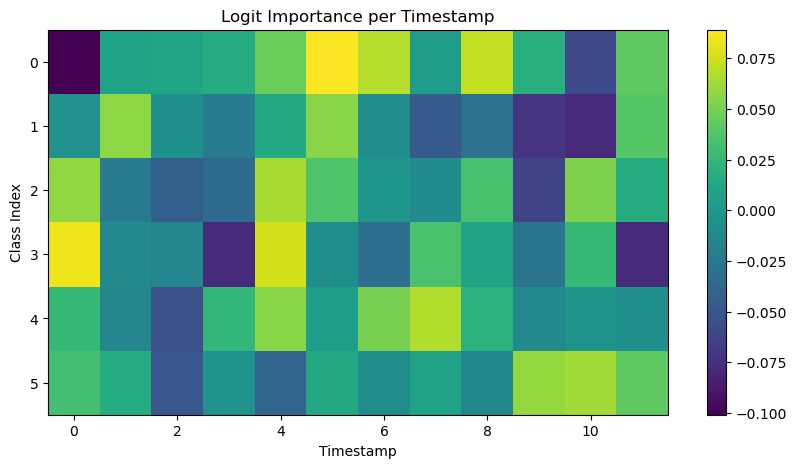

In [36]:
importance_scores = compute_logit_importance(model)
plot_logit_importance(importance_scores)

In [43]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt

def plot_logit_importance(importance_scores, title="Temporal Importance on Logits"):
    """
    중요도 행렬을 Heatmap으로 시각화하는 함수.

    Args:
        importance_scores (torch.Tensor): (num_classes=6, temp=12) 크기의 텐서
        title (str): 그래프 제목
    """
    # (6,12) 크기의 중요도 텐서를 NumPy로 변환
    importance_np = importance_scores.cpu().detach().numpy()  # (6,12)
    
    # 클래스별 정규화: 각 클래스 내에서 12시기의 합이 1이 되도록
    importance_sum = importance_np.sum(axis=1, keepdims=True)  # (6,1)
    importance_np = importance_np / importance_sum  # (6,12) (각 행의 합이 1)

    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(importance_np, annot=True, fmt=".2f", cmap="viridis",
                     xticklabels=[f"T{i+1}" for i in range(12)],  # 12개 시간 축
                     yticklabels=[f"Class {i}" for i in range(6)])  # 6개 클래스 축

    plt.xlabel("Time Steps")
    plt.ylabel("Classes")
    plt.title(title)

    # Colorbar 설정 (오류 방지)
    cbar = ax.collections[0].colorbar
    cbar.set_label("Normalized Importance")

    plt.show()


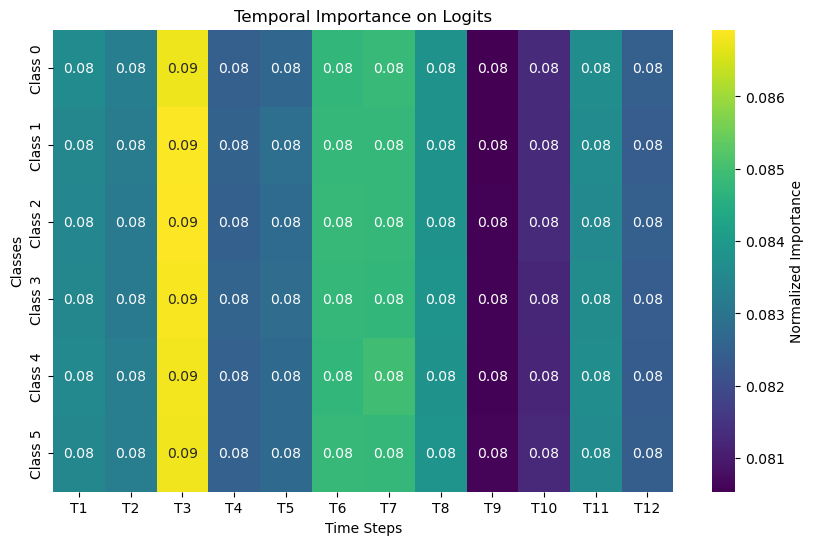

In [48]:
importance_scores = analyze_time_step_importance(model)
plot_logit_importance(importance_scores)

In [45]:
importance_scores.shape

torch.Size([12, 6])

In [8]:
import torch

def compute_time_class_weights(model):
    """
    (시기, 클래스) 가중치를 계산하는 함수
    - 기존 compute_feature_logit_weights 로직을 참고하여 구현
    """
    layers = model.fc_layers  # FC 레이어 가져오기
    num_features = layers[0].in_features  # 입력 피처 개수
    num_logits = layers[-1].out_features  # 출력 로짓 개수
    
    num_time_steps = 12  # 시기 개수
    d_model = num_features // num_time_steps  # 시기별 feature 개수

    # (Flatten된 피처, 클래스) → (시기, 클래스)로 변환
    time_class_weights = torch.zeros(num_time_steps, num_logits)

    for t in range(num_time_steps):
        start_idx = t * d_model
        end_idx = (t + 1) * d_model

        # 특정 시기의 모든 feature에 대해 경로 가중치를 계산
        weights = torch.zeros(d_model, num_logits)

        for input_idx in range(start_idx, end_idx):
            for logit_idx in range(num_logits):
                weight_values = []

                def traverse(layer_idx, current_weight):
                    if layer_idx == len(layers):  # 마지막 레이어 도달
                        weight_values.append(abs(current_weight))
                        return

                    fc_layer = layers[layer_idx]
                    next_weights = fc_layer.weight[:, input_idx]  # 해당 입력 피처와 연결된 가중치들

                    for next_idx, w in enumerate(next_weights):
                        traverse(layer_idx + 1, current_weight * w.item())

                traverse(0, 1)  # DFS 수행
                weights[input_idx - start_idx, logit_idx] = sum(weight_values) / len(weight_values)  # 평균 가중치 저장

        time_class_weights[t] = weights.mean(dim=0)  # 시기별 평균 가중치

    return time_class_weights.cpu().numpy()


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_time_class_weights(time_class_weights):
    """
    (시기, 클래스) 가중치를 시각화하는 함수
    """
    plt.figure(figsize=(10, 6))
    sns.heatmap(time_class_weights, annot=True, fmt=".4f", cmap="viridis", xticklabels=range(1, 13), yticklabels=range(1, 7))
    plt.xlabel("Time Step")
    plt.ylabel("Class")
    plt.title("(Time, Class) Weight Map")
    plt.show()


In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # 진행률 표시 라이브러리

def compute_time_class_weights(model):
    """
    (시기, 클래스) 가중치를 계산하는 함수
    """
    layers = [layer for layer in model.fc if isinstance(layer, torch.nn.Linear)]  # Linear 레이어만 선택
    num_features = layers[0].in_features  # 입력 feature 개수 (768)
    num_logits = layers[-1].out_features  # 출력 로짓 개수 (6)

    num_time_steps = 12
    d_model = num_features // num_time_steps  # 각 시기의 feature 수 (64)

    time_class_weights = torch.zeros(num_time_steps, num_logits)

    for t in tqdm(range(num_time_steps), desc="Computing time-class weights"):  # 진행률 표시
        start_idx = t * d_model
        end_idx = (t + 1) * d_model

        weights = torch.zeros(d_model, num_logits)

        for input_idx in range(start_idx, end_idx):
            print(input_idx)
            for logit_idx in range(num_logits):
                weight_values = []

                def traverse(layer_idx, current_weight):
                    if layer_idx == len(layers):  # 마지막 레이어 도달
                        weight_values.append(abs(current_weight))
                        return

                    fc_layer = layers[layer_idx]
                    next_weights = fc_layer.weight[:, input_idx]  # 현재 input_idx와 연결된 가중치들

                    for next_idx, w in enumerate(next_weights):
                        traverse(layer_idx + 1, current_weight * w.item())

                traverse(0, 1)
                weights[input_idx - start_idx, logit_idx] = sum(weight_values) / len(weight_values)

        time_class_weights[t] = weights.mean(dim=0)  # 해당 시기의 평균 가중치

    return time_class_weights.cpu().numpy()

def plot_time_class_weights(time_class_weights):
    """
    (시기, 클래스) 가중치를 시각화하는 함수
    """
    plt.figure(figsize=(10, 6))
    num_time_steps, num_classes = time_class_weights.shape

    for c in range(num_classes):
        plt.plot(range(num_time_steps), time_class_weights[:, c], marker='o', label=f'Class {c}')

    plt.xlabel('Time Step')
    plt.ylabel('Average Weight')
    plt.title('Time-Class Weights')
    plt.legend()
    plt.grid()
    plt.show()

# 실행 예시
time_class_weights = compute_time_class_weights(model)
plot_time_class_weights(time_class_weights)


Computing time-class weights:   0%|                                                                                                                                        | 0/12 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


Computing time-class weights:   0%|                                                                                                                                        | 0/12 [02:10<?, ?it/s]


KeyboardInterrupt: 

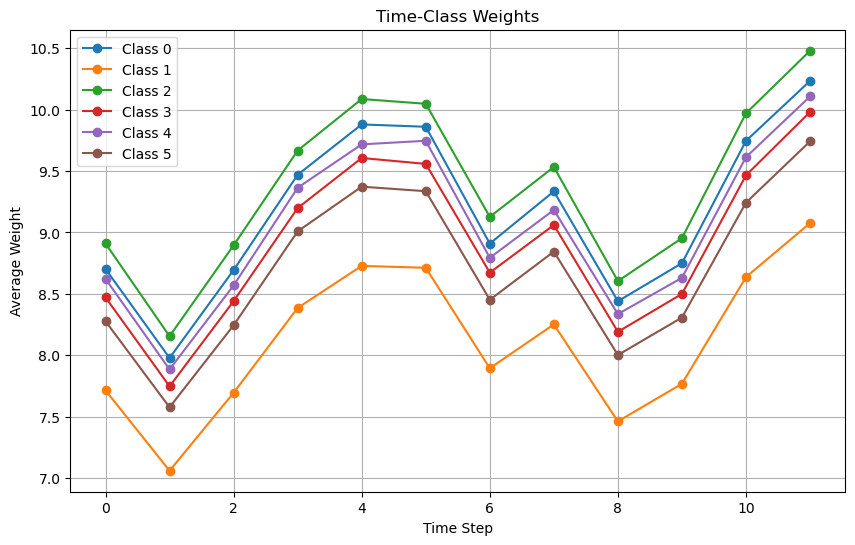

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def compute_time_class_weights_fast(model):
    """
    (시기, 클래스) 가중치를 빠르게 계산하는 함수
    """
    # 모델이 위치한 디바이스 확인
    device = next(model.parameters()).device

    # FC 레이어만 추출 (Dropout, ReLU 등 제외)
    layers = [layer for layer in model.fc if isinstance(layer, torch.nn.Linear)]

    num_features = layers[0].in_features  # 입력 feature 개수 (768)
    num_logits = layers[-1].out_features  # 출력 로짓 개수 (6)

    num_time_steps = 12
    d_model = num_features // num_time_steps  # 각 시기의 feature 수 (64)

    # 가중치 행렬을 모델과 동일한 디바이스로 생성
    weight_matrix = torch.eye(num_features, device=device)

    # 모든 FC 레이어를 거치며 가중치를 누적 곱
    for layer in layers:
        weight_matrix = torch.matmul(weight_matrix, layer.weight.T.abs())  # 절댓값을 취하여 영향력 측정

    # (num_time_steps, d_model, num_logits) 형태로 변환
    weight_matrix = weight_matrix.view(num_time_steps, d_model, num_logits)

    # 각 시기의 평균 가중치 계산 (CPU로 이동하여 numpy 변환)
    time_class_weights = weight_matrix.mean(dim=1).detach().cpu().numpy()

    return time_class_weights

def plot_time_class_weights(time_class_weights):
    """
    (시기, 클래스) 가중치를 시각화하는 함수
    """
    plt.figure(figsize=(10, 6))
    num_time_steps, num_classes = time_class_weights.shape

    for c in range(num_classes):
        plt.plot(range(num_time_steps), time_class_weights[:, c], marker='o', label=f'Class {c}')

    plt.xlabel('Time Step')
    plt.ylabel('Average Weight')
    plt.title('Time-Class Weights')
    plt.legend()
    plt.grid()
    plt.show()

# 실행 예시
time_class_weights = compute_time_class_weights_fast(model)
plot_time_class_weights(time_class_weights)


In [27]:
for layer in model.transformer.layers:
    layer.self_attn.need_weights = True

In [28]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

def extract_attention_weights(model, x):
    """
    Transformer 모델에서 Self-Attention Score를 추출하는 함수
    - model: TransformerModel 인스턴스
    - x: 입력 데이터 (batch, 4, 12, 9, 9)
    - return: attention_weights (list of tensors)
    """
    attention_weights = []

    def hook(module, input, output):
        # output[1] = (batch, num_heads, num_tokens, num_tokens)
        attention_weights.append(output[1].detach().cpu())

    # Transformer Encoder Layer의 Multi-Head Self-Attention 레이어에 hook 추가
    for layer in model.transformer.layers:
        layer.self_attn.register_forward_hook(hook)

    _ = model(x)  # Forward pass → attention score 저장

    return attention_weights  # 각 Transformer Layer의 Attention Map 리스트 반환


In [29]:
def plot_attention_map(attn_weights, layer_idx=0, head_idx=0):
    """
    Attention Weight를 Heatmap으로 시각화
    - attn_weights: extract_attention_weights()의 출력값
    - layer_idx: 시각화할 Transformer Layer 선택
    - head_idx: 시각화할 Attention Head 선택
    """
    attn = attn_weights[layer_idx][0, head_idx]  # 첫 번째 샘플의 특정 Head Attention Map

    plt.figure(figsize=(8, 6))
    sns.heatmap(attn, annot=False, cmap="coolwarm", xticklabels=range(1, 13), yticklabels=range(1, 13))
    plt.xlabel("Attended Time Step")
    plt.ylabel("Query Time Step")
    plt.title(f"Attention Map (Layer {layer_idx+1}, Head {head_idx+1})")
    plt.show()

In [30]:
# 예제 입력 데이터 (batch=1, 4 bands, 12 time steps, 9×9 patch)
x_sample = torch.randn(1, 4, 12, 9, 9)  

# Transformer 모델 초기화 (사용자 모델 적용)
model = TransformerModel()

# Attention Map 추출
attn_weights = extract_attention_weights(model, x_sample)

# 1번째 Layer, 1번째 Attention Head 시각화
plot_attention_map(attn_weights, layer_idx=0, head_idx=0)

AttributeError: 'NoneType' object has no attribute 'detach'